<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Credit-risk-and-bucketing" data-toc-modified-id="Credit-risk-and-bucketing-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Credit risk and bucketing</a></span></li><li><span><a href="#Load-dataset" data-toc-modified-id="Load-dataset-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Load dataset</a></span></li><li><span><a href="#EDA" data-toc-modified-id="EDA-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>EDA</a></span></li><li><span><a href="#Optimal-number-of-clusters" data-toc-modified-id="Optimal-number-of-clusters-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Optimal number of clusters</a></span><ul class="toc-item"><li><span><a href="#Elbow-method" data-toc-modified-id="Elbow-method-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Elbow method</a></span></li><li><span><a href="#Silhouette-method" data-toc-modified-id="Silhouette-method-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Silhouette method</a></span></li><li><span><a href="#Calinski-Harabasz-(CH)-method" data-toc-modified-id="Calinski-Harabasz-(CH)-method-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Calinski-Harabasz (CH) method</a></span></li><li><span><a href="#Gap-analysis" data-toc-modified-id="Gap-analysis-6.4"><span class="toc-item-num">6.4&nbsp;&nbsp;</span>Gap analysis</a></span></li></ul></li><li><span><a href="#Chosen-optimal-number-of-clusters" data-toc-modified-id="Chosen-optimal-number-of-clusters-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Chosen optimal number of clusters</a></span></li><li><span><a href="#References" data-toc-modified-id="References-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>References</a></span></li></ul></div>

# Introduction
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-warning">
<font color=black>

**What?** 4 methods to find the optimal number of clusters

</font>
</div>

# Imports
<hr style = "border:2px solid black" ></hr>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
from gap_statistic.optimalK import OptimalK
import seaborn as sns
import pymc3 as pm
import arviz as az
import logging
sns.set()
plt.rcParams["figure.figsize"] = (10,6)

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Credit risk and bucketing
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-info">
<font color=bla ck>

- **Credit risk** is most simply defined as the potential that a bank borrower or counterparty will fail to meet its obligations in accordance with agreed terms. The goal of credit risk management is to maximise a bank’s risk-adjusted rate of return by maintaining credit risk exposure within acceptable parameters. The importance of having strong capital requirements for a bank rests on the idea that banks should have a capital buffer in turbulent times. Of course, ensuring at least a minimum capital requirement is a burden for financial institutions in the sense that capital is an asset they cannot channel to deficit entities to make a profit.                 
The most important and challenging part of estimating credit risk is to model the probability of default.


- **Risk bucketing** is nothing but grouping borrowers with similar creditworthiness. The behind-the-scenes story of risk bucketing is to obtain homogenous groups or clusters so that we can better estimate the credit risk. 
Treating different risky borrowers equally may result in poor predictions because the model cannot capture entirely different characteristics of the data at once. 
Thus, by dividing the borrowers into different groups based on riskiness, risk bucketing enables us to make accurate predictions.

</font>
</div>

# Load dataset
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-info">
<font color=bla ck>

- Let’s create a practice exer‐ cise using German credit risk data. 
- The data is gathered from the Kaggle platform.
- The dataset includes both categorical and numerical values, which need to be treated differently.

</font>
</div>

In [3]:
credit = pd.read_csv('credit_data_risk.csv')

# EDA
<hr style = "border:2px solid black" ></hr>

In [4]:
credit.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


In [5]:
del credit['Unnamed: 0']

In [6]:
credit.describe()

,Age,Job,Credit amount,Duration
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,35.546000,1.904000,3271.258000,20.903000
std,11.375469,0.653614,2822.736876,12.058814
min,19.000000,0.000000,250.000000,4.000000
25%,27.000000,2.000000,1365.500000,12.000000
50%,33.000000,2.000000,2319.500000,18.000000
75%,42.000000,2.000000,3972.250000,24.000000
max,75.000000,3.000000,18424.000000,72.000000


In [7]:
numerical_credit = credit.select_dtypes(exclude='O')

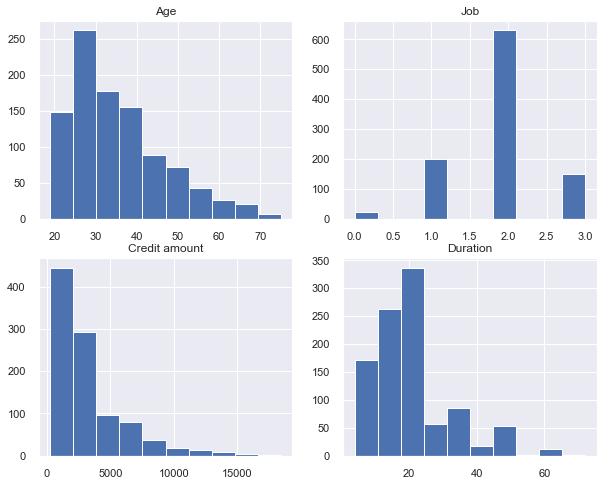

In [8]:
plt.figure(figsize=(10, 8))
k = 0
cols = numerical_credit.columns
for i, j in zip(range(len(cols)), cols):
    k +=1
    plt.subplot(2, 2, k)
    plt.hist(numerical_credit.iloc[:, i])
    plt.title(j)

# Optimal number of clusters
<hr style = "border:2px solid black" ></hr>

In [9]:
scaler = StandardScaler()
scaled_credit = scaler.fit_transform(numerical_credit)

## Elbow method

<div class="alert alert-info">
<font color=bla ck>

- the **elbow method** is based on the inertia.
- The elbow method is used to find the optimal number of clusters, we observe the slope of the curve and decide the cut-off point at which the curve gets flatter—that is, the slope of the curve gets lower. 
- As it gets flatter, the inertia, telling us how far away the points within a cluster are located, decreases, which is nice for the purpose of clustering. On the other hand, as we allow inertia to decrease, the number of clusters increases, which makes the analysis more complicated. Given that trade-off, the stopping criteria is the point where the **curve gets flatter**.

</font>
</div>

In [10]:
distance = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(scaled_credit)
    distance.append(kmeans.inertia_)

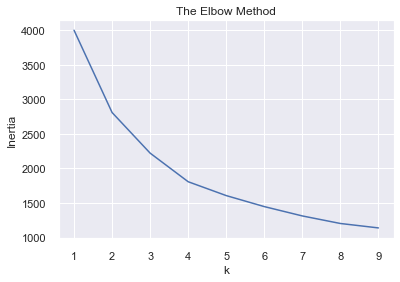

In [11]:
plt.plot(range(1, 10), distance, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('The Elbow Method')
plt.show()

## Silhouette method

<div class="alert alert-info">
<font color=bla ck>

- The Silhouette score is introduced as a tool to decide the optimal number of clusters. This takes a value between 1 and -1. 
- A value of 1 indicates that an observation is close to the correct centroid and correctly classified. However, -1 shows that an observation is not correctly clustered.
- The strength of the Silhouette score rests on taking into account both the intracluster distance and the intercluster distance.

</font>
</div>

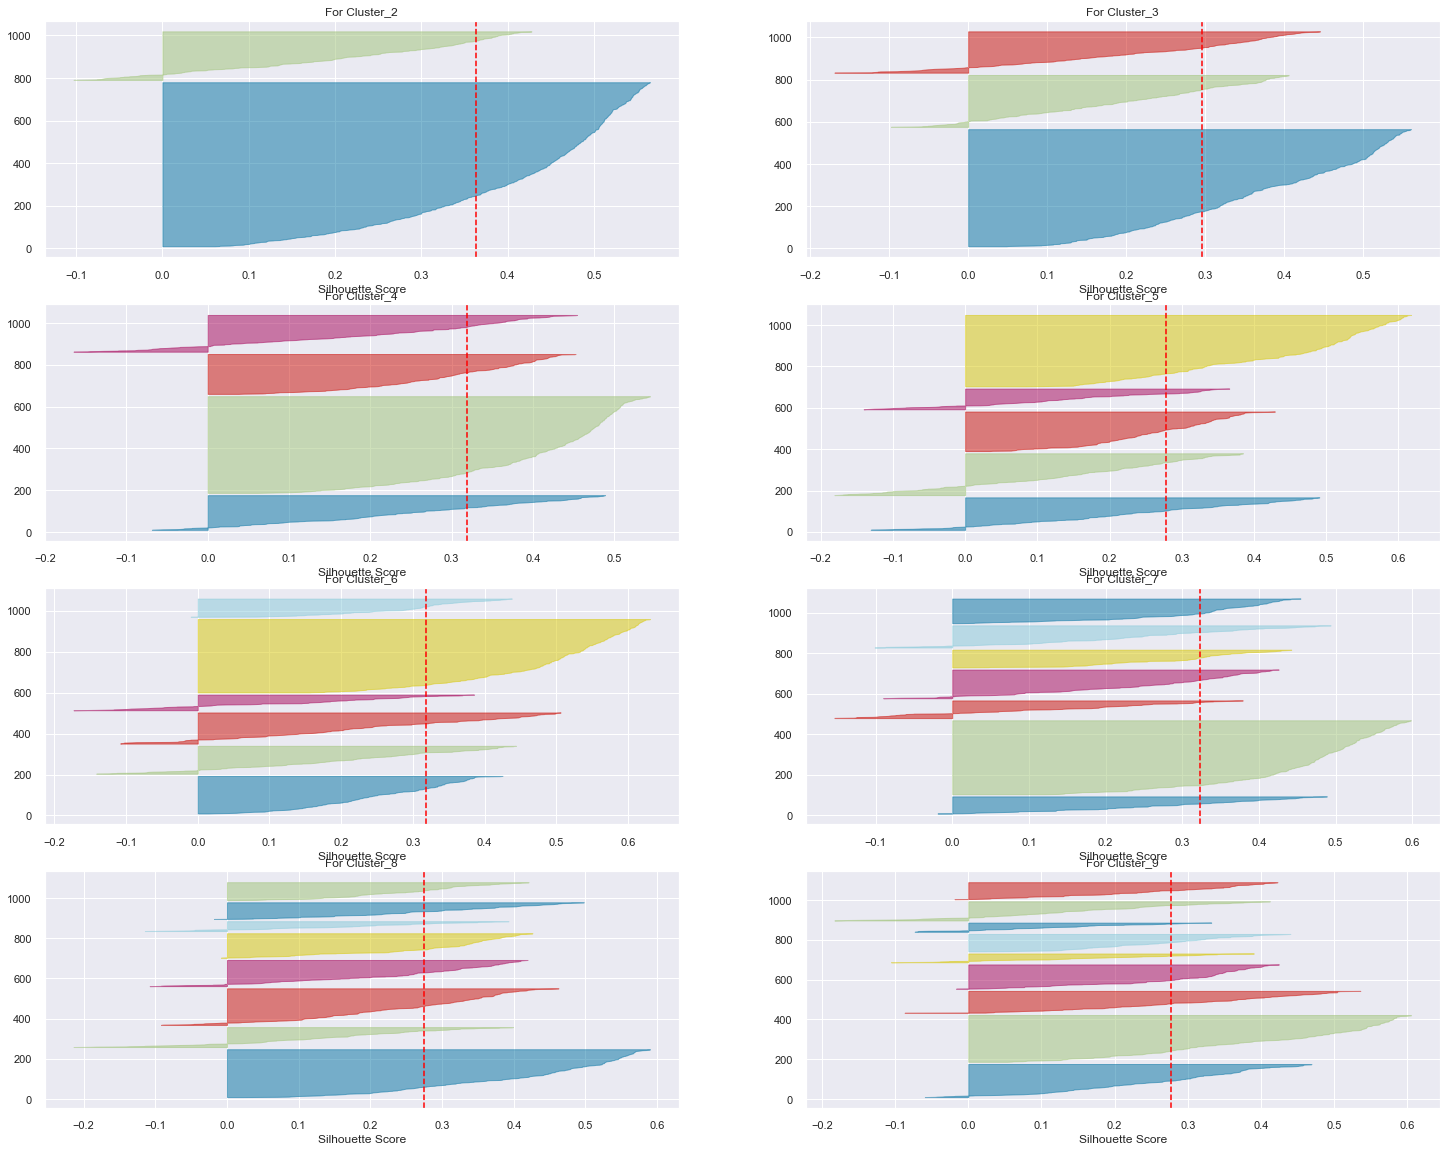

In [12]:
fig, ax = plt.subplots(4, 2, figsize=(25, 20))
for i in range(2, 10):
    km = KMeans(n_clusters=i)
    q, r = divmod(i, 2)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick',
                                      ax=ax[q - 1][r])
    visualizer.fit(scaled_credit)
    ax[q - 1][r].set_title("For Cluster_"+str(i))
    ax[q - 1][r].set_xlabel("Silhouette Score")

## Calinski-Harabasz (CH) method

<div class="alert alert-info">
<font color=bla ck>

- Calinski-Harabasz (CH), which is known as the variance ratio criterion.
- We are seeking a high CH score, as the larger (lower) the between-cluster variance (within cluster variance), the better it is for finding the optimal number of clusters.

</font>
</div>

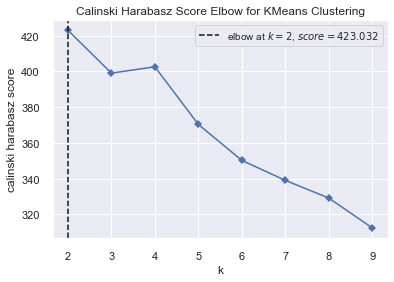

In [13]:
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2, 10),
                              metric='calinski_harabasz',
                              timings=False)
visualizer.fit(scaled_credit)
visualizer.show();

## Gap analysis

<div class="alert alert-info">
<font color=bla ck>

- The estimate of the optimal clusters will be the value that maximizes the **gap statistic**, as the gap statistic is the difference between the total within-intracluster variation for different values of k and their expected values under null reference distribution of the respective data. 
- The decision is made when we get the highest gap value.

</font>
</div>

In [14]:
optimalK = OptimalK(n_jobs=8, parallel_backend='joblib')
n_clusters = optimalK(scaled_credit, cluster_array=np.arange(1, 10))

In [15]:
gap_result = optimalK.gap_df
gap_result.head()

,n_clusters,gap_value,gap*,ref_dispersion_std,sk,sk*,diff,diff*
0,1.0,0.904292,5881.377355,112.484185,0.013188,6792.471547,-0.010402,6606.502283
1,2.0,0.967596,4591.935115,342.749939,0.052901,5317.060043,-0.039590,5211.627891
2,3.0,1.028523,3993.342301,115.268080,0.021337,4613.035077,0.000771,4516.795795
3,4.0,1.039497,3380.514331,53.352034,0.011745,3903.967825,-0.008659,3879.512065
4,5.0,1.063966,3220.362582,67.050058,0.015809,3719.360316,0.025754,3674.032066


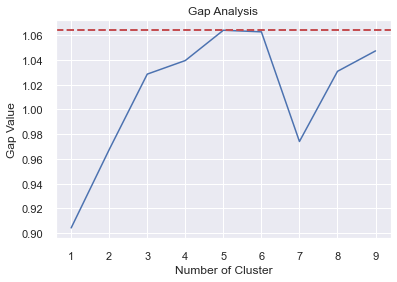

In [16]:
plt.plot(gap_result.n_clusters, gap_result.gap_value)
min_ylim, max_ylim = plt.ylim()
plt.axhline(np.max(gap_result.gap_value), color='r',
            linestyle='dashed', linewidth=2)
plt.title('Gap Analysis')
plt.xlabel('Number of Cluster')
plt.ylabel('Gap Value')
plt.show()

# Chosen optimal number of clusters
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-info">
<font color=bla ck>

- In light of these discussions, two clusters are chosen to be the optimal number of clusters, and the K-means clustering analysis is conducted accordingly. 
- To illustrate the result let's visualize 2-D clusters.

</font>
</div>

In [17]:
kmeans = KMeans(n_clusters=2)
clusters = kmeans.fit_predict(scaled_credit)

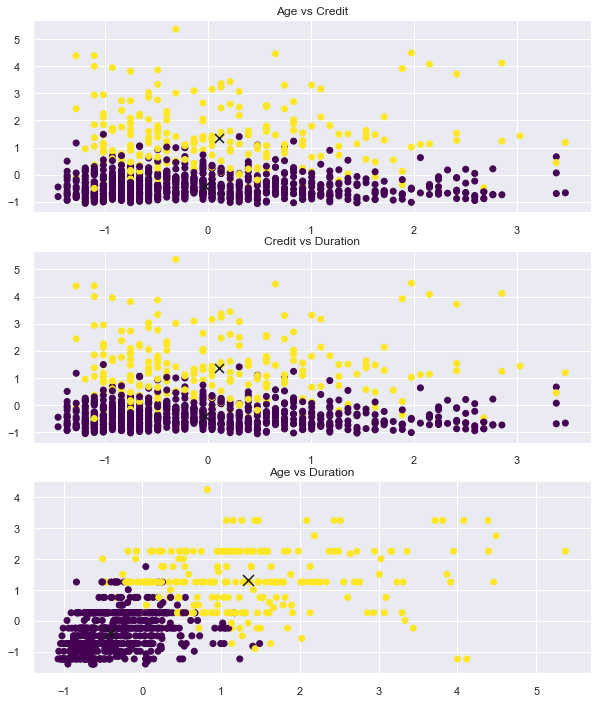

In [18]:
plt.figure(figsize=(10, 12))
plt.subplot(311)
plt.scatter(scaled_credit[:, 0], scaled_credit[:, 2],
            c=kmeans.labels_, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0],
            kmeans.cluster_centers_[:, 2], s = 80,
            marker= 'x', color = 'k')
plt.title('Age vs Credit')
plt.subplot(312)
plt.scatter(scaled_credit[:, 0], scaled_credit[:, 2],
            c=kmeans.labels_, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0],
            kmeans.cluster_centers_[:, 2], s = 80,
            marker= 'x', color = 'k')
plt.title('Credit vs Duration')
plt.subplot(313)
plt.scatter(scaled_credit[:, 2], scaled_credit[:, 3],
            c=kmeans.labels_, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 2],
            kmeans.cluster_centers_[:, 3], s = 120,
            marker= 'x', color = 'k')
plt.title('Age vs Duration')
plt.show()

In [19]:
clusters, counts = np.unique(kmeans.labels_, return_counts=True)

In [20]:
cluster_dict = {}
for i in range(len(clusters)):
    cluster_dict[i] = scaled_credit[np.where(kmeans.labels_==i)]

In [21]:
credit['clusters'] = pd.DataFrame(kmeans.labels_)

In [22]:
df_scaled = pd.DataFrame(scaled_credit)
df_scaled['clusters'] = credit['clusters']

In [23]:
df_scaled['Risk'] = credit['Risk']
df_scaled.columns = ['Age', 'Job', 'Credit amount',
                     'Duration', 'Clusters', 'Risk']

In [24]:
df_scaled[df_scaled.Clusters == 0]['Risk'].value_counts()

good    572
bad     192
Name: Risk, dtype: int64

In [25]:
df_scaled[df_scaled.Clusters == 1]['Risk'].value_counts()

good    128
bad     108
Name: Risk, dtype: int64

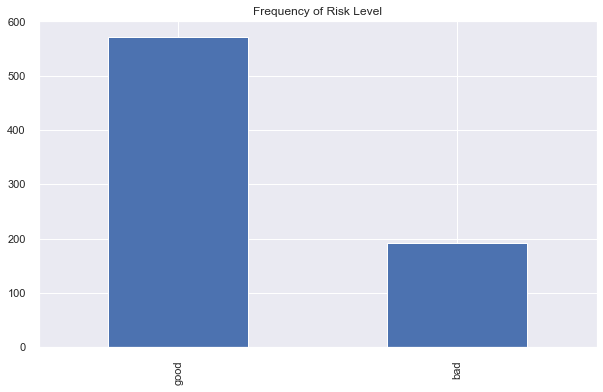

In [26]:
df_scaled[df_scaled.Clusters == 0]['Risk'].value_counts()\
                                    .plot(kind='bar',
                                    figsize=(10, 6),
                                    title="Frequency of Risk Level")
plt.show()

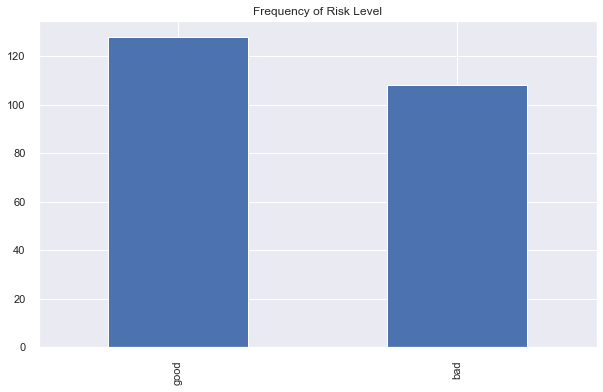

In [27]:
df_scaled[df_scaled.Clusters == 1]['Risk'].value_counts()\
                                    .plot(kind='bar',
                                    figsize=(10, 6),
                                    title="Frequency of Risk Level")
plt.show()

# References
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-warning">
<font color=black>

- Machine Learning for Financial Risk Management with Python Abdullah Karasan
- [Kaggle dataset download link](https://www.kaggle.com/datasets/uciml/german-credit)

</font>
</div>